# Model 2 - PointNet Basic

## Prediction of radiotherapy plan violation from spatial arrangement of target and organ at risk structures using deep learning

_By Phillip Hungerford,  University of New South Wales_

## PointNet Basic Model Testing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive

/content/drive


In [3]:
cd My Drive

/content/drive/My Drive


In [4]:
cd Dissertation/5_Code/1_code

/content/drive/My Drive/Dissertation/5_Code/1_code


In [5]:
ls

 DataPreparation.ipynb          Model5_ANN.ipynb
'EDA&PreProcessing.ipynb'       my_model_16_16_16.h5
 keras-test.ipynb               original-voxel-model.ipynb
 Model1_PointNetFull.ipynb      PointNetBasic.ipynb
 Model2_PointNetBasic.ipynb     Py/
 Model3_PointNetBasic_l.ipynb   __pycache__/
 Model4_3DCNN.ipynb             voxel-model.ipynb


## 1. Set Seed for Reproducibility

In [6]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


## 2. Install dependencies

In [0]:
# Import dependencies
import os
import time
import random
import numpy as np
import tensorflow as tf
from numpy.random import seed
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from tensorflow import set_random_seed
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, auc, confusion_matrix
from keras.layers import Dense, MaxPooling1D, Convolution1D, Dropout, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

## 3. Load data

In [8]:
num_points=3140
X = np.load('../2_pipeline/3140-xyz.npy')
y = np.load('../2_pipeline/labels.npy')

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

#from keras.utils import to_categorical
#y_test = to_categorical(y_test)
#y_train = to_categorical(y_train)

print('Training shape is: ', X_train.shape)
print('Validation shape is: ', X_val.shape)
print('Test shape is: ', X_test.shape)

Training shape is:  (182, 3140, 3)
Validation shape is:  (46, 3140, 3)
Test shape is:  (58, 3140, 3)


## 4. Build Model

In [9]:
# hyperparameters
# number of categories
k = 1
# define optimizer
opt = Adam(lr=0.001, decay=0.7)
max_epochs=25
batch_size=32
dropout_rate = 0.7

# Class weights
class_weight = {0: 0.2, 1: 0.8}

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
################################################################################
### POINTNET ARCHITECTURE
################################################################################
# Point functions (MLP implemented as conv1d)
model = Sequential()
model.add(Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(128, 1, activation='relu'))
model.add(Convolution1D(1024, 1, activation='relu'))

# Symmetric function: max pooling
model.add(MaxPooling1D(pool_size=num_points))

#fully connected
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(1, activation='sigmoid'))
model.add(Flatten())

 # MLP on global point cloud vector
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 3140, 64)          256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3140, 64)          4160      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3140, 64)          4160      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 3140, 128)         8320      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3140, 1024)        132096    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 1024)           0         
___________________________

## 5. Train & Evaluate Model

In [11]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs,\
                    shuffle=True, verbose=1, validation_data=(X_val, y_val),\
                    class_weight=class_weight)

# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Average loss of: ", scores[0])
print("Average accuracy of: ", scores[1])

Instructions for updating:
Use tf.cast instead.
Train on 182 samples, validate on 46 samples
Epoch 1/25
182/182 [==============================] - 5s 26ms/step - loss: 0.8875 - acc: 0.4780 - val_loss: 1.0089 - val_acc: 0.6739
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 1.1155 - acc: 0.5330 - val_loss: 0.8687 - val_acc: 0.6739
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 1.1826 - acc: 0.4780 - val_loss: 0.8229 - val_acc: 0.5217
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 0.8531 - acc: 0.4945 - val_loss: 0.8623 - val_acc: 0.5217
Epoch 5/25
182/182 [==============================] - 1s 7ms/step - loss: 1.0529 - acc: 0.4505 - val_loss: 0.8766 - val_acc: 0.5217
Epoch 6/25
182/182 [==============================] - 1s 7ms/step - loss: 0.8049 - acc: 0.5549 - val_loss: 0.8911 - val_acc: 0.5217
Epoch 7/25
182/182 [==============================] - 1s 7ms/step - loss: 0.8302 - acc: 0.5055 - val_loss: 0.8833 


###################### Model Performance ############################

Train: 0.599, Test: 0.690

#####################################################################

Our test confusion matrix yields: 


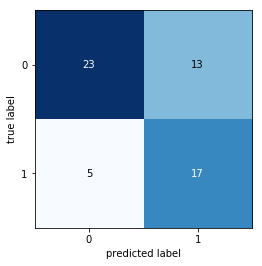


#####################################################################

Classfication Report for test:
               precision    recall  f1-score   support

         0.0       0.82      0.64      0.72        36
         1.0       0.57      0.77      0.65        22

   micro avg       0.69      0.69      0.69        58
   macro avg       0.69      0.71      0.69        58
weighted avg       0.72      0.69      0.69        58


#####################################################################

The AUC is 0.7487373737373737


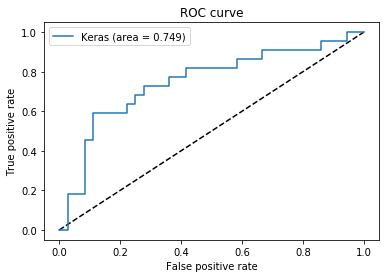

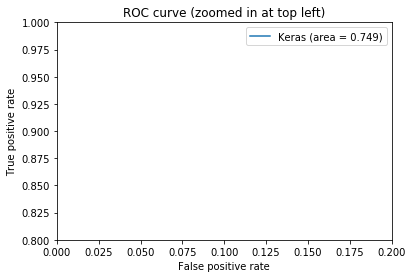


#####################################################################


In [12]:
print("\n###################### Model Performance ############################")
# Make predictions 
y_pred = model.predict(X_test)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
print("\n#####################################################################")

# Create the confusion matrix
ann_cm = confusion_matrix(y_true = y_test, y_pred = y_pred.round())
print("\nOur test confusion matrix yields: ")
fig, ax = plot_confusion_matrix(conf_mat=ann_cm)
plt.show()
print("\n#####################################################################")

#Classification report
ann_report = classification_report(y_test, y_pred.round())
print("\nClassfication Report for test:\n", ann_report)
print("\n#####################################################################")

# Plot AUC
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = auc(fpr, tpr)

print("\nThe AUC is", auc)
# Create AUC plot
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()
print("\n#####################################################################")

In [0]:
################################################################################
# Save model
#import pickle

# Save history
#with open('/trainHistoryDict', 'wb') as file_pi:
        #pickle.dump(history.history, file_pi)

# Save model
#from keras.models import load_model
#model.save('my_model'+str(num_points)+'4D.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

################################################################################

## Multi-class Model k=4, 0 = No violation, 1 = bladder violation, 2 = rectum violation, 3 = both

In [67]:
num_points=3140
X = np.load('../2_pipeline/3140-xyz.npy')
y = np.load('../2_pipeline/labels_k4.npy')

#split data into 1: train+validation set and 2: test set 
X_train_val, X_test, y_train_val, y_test = \
train_test_split(X, y, random_state=0, test_size=0.2)

# split train+validation set into 1a) training and 1b) validation sets
X_train, X_val, y_train, y_val = \
train_test_split(X_train_val, y_train_val, random_state=1, test_size=0.2)

from keras.utils import to_categorical
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
y_train = to_categorical(y_train)

print('Training shape is: ', X_train.shape)
print('Validation shape is: ', X_val.shape)
print('Test shape is: ', X_test.shape)

bladder_proportion = round(sum(y==1)/268,2)
rectum_proportion = round(sum(y==2)/268,2)
both_proportion = round(sum(y==3)/268,2)
total = round(bladder_proportion+rectum_proportion+both_proportion,2)

print()
print("Proportion of bladder violations: ", bladder_proportion)
print("Proportion of rectum violations: ", rectum_proportion)
print("Proportion of both violations: ", both_proportion)
print("Proportion of no violations: ", round(1-total,2))

Training shape is:  (182, 3140, 3)
Validation shape is:  (46, 3140, 3)
Test shape is:  (58, 3140, 3)

Proportion of bladder violations:  0.04
Proportion of rectum violations:  0.25
Proportion of both violations:  0.03
Proportion of no violations:  0.68


In [0]:
# Class weights
class_weight = { 0:1, 1:8, 2:4, 3:8}

In [81]:
################################################################################
### POINTNET ARCHITECTURE
################################################################################
# Point functions (MLP implemented as conv1d)
model = Sequential()
model.add(Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(64, 1, activation='relu'))
model.add(Convolution1D(128, 1, activation='relu'))
model.add(Convolution1D(1024, 1, activation='relu'))

# Symmetric function: max pooling
model.add(MaxPooling1D(pool_size=num_points))

#fully connected
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(4, activation='sigmoid'))
model.add(Flatten())

 # MLP on global point cloud vector
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, 3140, 64)          256       
_________________________________________________________________
conv1d_57 (Conv1D)           (None, 3140, 64)          4160      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 3140, 64)          4160      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 3140, 128)         8320      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, 3140, 1024)        132096    
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 1, 1024)           0         
_________________________________________________________________
dense_34 (Dense)             (None, 1, 512)            524800    
__________

In [82]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs,\
                    shuffle=True, verbose=1, validation_data=(X_val, y_val),\
                    class_weight=class_weight)

# Evaluate Model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Average loss of: ", scores[0])
print("Average accuracy of: ", scores[1])

Train on 182 samples, validate on 46 samples
Epoch 1/25
182/182 [==============================] - 4s 21ms/step - loss: 8.8217 - acc: 0.1868 - val_loss: 1.8941 - val_acc: 0.1957
Epoch 2/25
182/182 [==============================] - 1s 7ms/step - loss: 8.8840 - acc: 0.1648 - val_loss: 1.7613 - val_acc: 0.1957
Epoch 3/25
182/182 [==============================] - 1s 7ms/step - loss: 9.2390 - acc: 0.2802 - val_loss: 1.6566 - val_acc: 0.1957
Epoch 4/25
182/182 [==============================] - 1s 7ms/step - loss: 7.5115 - acc: 0.2692 - val_loss: 1.5636 - val_acc: 0.1957
Epoch 5/25
182/182 [==============================] - 1s 7ms/step - loss: 8.6589 - acc: 0.2308 - val_loss: 1.4795 - val_acc: 0.1957
Epoch 6/25
182/182 [==============================] - 1s 7ms/step - loss: 8.3612 - acc: 0.2802 - val_loss: 1.4198 - val_acc: 0.1957
Epoch 7/25
182/182 [==============================] - 1s 7ms/step - loss: 7.4404 - acc: 0.2418 - val_loss: 1.3746 - val_acc: 0.1957
Epoch 8/25
182/182 [==========

In [83]:
print("\n###################### Model Performance ############################")
# Make predictions 
y_pred = model.predict(X_test)

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTrain: %.3f, Test: %.3f' % (train_acc, test_acc))
print("\n#####################################################################")

#Classification report
ann_report = classification_report(y_test, y_pred.round())
print("\nClassfication Report for test:\n", ann_report)
print("\n#####################################################################")


###################### Model Performance ############################

Train: 0.242, Test: 0.259

#####################################################################

Classfication Report for test:
               precision    recall  f1-score   support

           0       0.69      0.69      0.69        39
           1       0.00      0.00      0.00         3
           2       0.26      1.00      0.41        15
           3       0.00      0.00      0.00         1

   micro avg       0.41      0.72      0.52        58
   macro avg       0.24      0.42      0.28        58
weighted avg       0.53      0.72      0.57        58
 samples avg       0.40      0.72      0.51        58


#####################################################################


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Proportion of bladder violations:  0.04
Proportion of rectum violations:  0.25
Proportion of both violations:  0.03
Proportion of no violations:  0.68
